# **We use** ResNet to preserve the spatial information of our inputs. We then extract the final feature map and apply the KMeans algorithm to perform unsupervised classification. To determine the optimal number of clusters "k", we use the Elbow Method. Finally, we apply a low-rank PCA to visualize the distribution of the extracted features in a reduced-dimensional space.

In [51]:
from get_data import extract_and_save_fits_images
import torch
import torchinfo
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
extract_and_save_fits_images(r"C:\Users\opera\OneDrive\Documentos\GitHub\EXXAtest\data", r"C:\Users\opera\OneDrive\Documentos\GitHub\EXXAtest\new_data")

Procesando FITS: 100%|██████████| 150/150 [00:02<00:00, 50.52it/s]


In [ ]:
from torchvision import transforms
from dataset import ImageFolderNoLabels
from torch.utils.data import DataLoader
image_dir = r"C:\Users\opera\OneDrive\Documentos\GitHub\EXXAtest\new_data"

# Transformación común
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # from [1,H,W] to [3,H,W]
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolderNoLabels(image_dir, transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=False) 

In [32]:
img = next(iter(loader))

In [33]:
img.shape

torch.Size([8, 3, 224, 224])

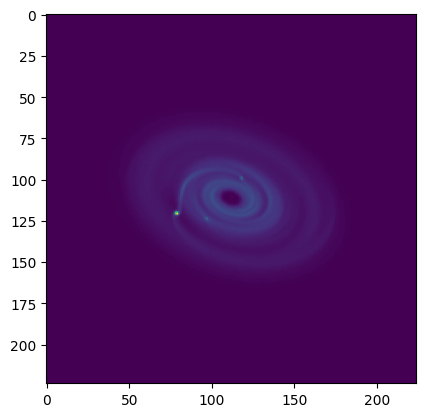

In [47]:
plt.imshow(img[0,0,:,:])

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
#load resnet50 model with pretrained weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).to(device)

In [36]:
torchinfo.summary(model, device=device.type)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [ ]:
# delete the final fc layer
feature_extractor = nn.Sequential(*list(model.children())[:-1]) 
feature_extractor.eval().cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
from sklearn.cluster import KMeans

# features maps extracted from the model
features = []

with torch.no_grad():
    for batch in loader:
        batch = batch.to(device) 
        out = feature_extractor(batch)
        out = out.view(out.size(0), -1)  # flatten the feature maps
        features.append(out.cpu())  # load in cpu to use sklearn

features = torch.cat(features, dim=0).numpy()  # (N, D)

kmeans = KMeans(n_clusters=3, random_state=42) #but why 3?
labels = kmeans.fit_predict(features)

print("label per images", labels)

Etiquetas por imagen: [1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 2 2 2 1 1 1 1 0 2 0 0 1 0 1 1 0 2
 2 0 0 0 0 1 0 2 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 2 2 2 1 2 0 0 1 1 1 0 0 0 2
 2 2 2 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 2 2 0 1 1 1 1 0 1 0 0 0 0 0 1 1
 2 2 0 1 1 1 2 2 2 2 2 2 2 2 2 0 1 1 0 1 1 1 1 2 1 1 2 2 2 2 2 1 1 1 1 0 2
 1 1]


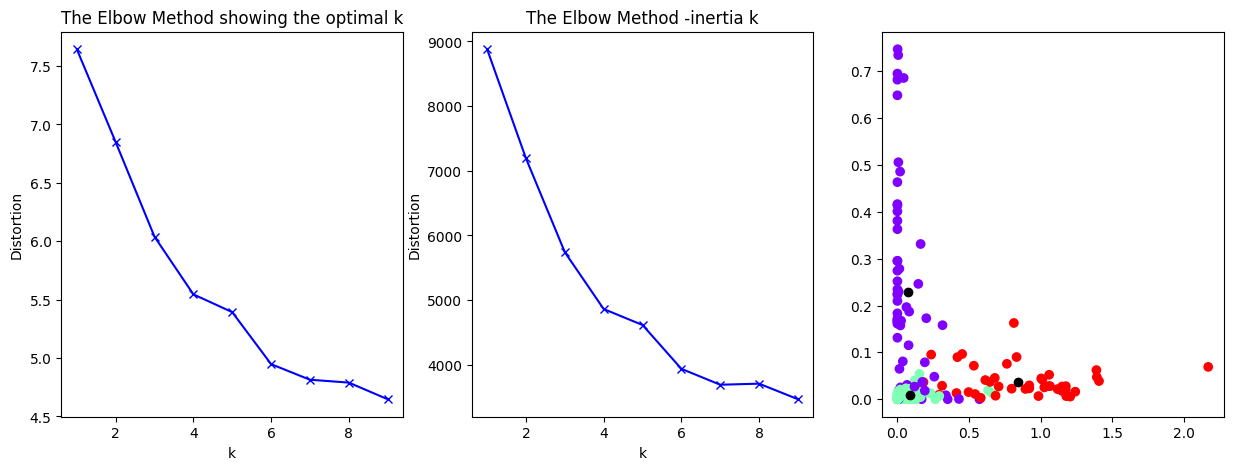

In [54]:
# Elbow approach
from scipy.spatial.distance import cdist
distortions = []
wss = [] #Within-Cluster-Sum of Squared
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(features)
    kmeanModel.fit(features)
    distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])
    wss.append(kmeanModel.inertia_)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(K, distortions, 'bx-'); plt.xlabel('k');plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.subplot(132)
plt.plot(K, wss, 'bx-'); plt.xlabel('k');plt.ylabel('Distortion')
plt.title('The Elbow Method -inertia k')
plt.subplot(133)
kmeanModel = KMeans(n_clusters=3, n_init='auto').fit(features)
kmeanModel.fit(features)
plt.scatter(features[:,0], features[:,1], c=kmeanModel.labels_, cmap='rainbow');
plt.scatter(kmeanModel.cluster_centers_[:,0] ,kmeanModel.cluster_centers_[:,1], color='black')

C:\Users\opera\AppData\Local\Temp\ipykernel_10088\3918738083.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(set(labels)))
C:\Users\opera\AppData\Local\Temp\ipykernel_10088\3918738083.py:20: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette=cmap.colors, alpha=0.7)


Text(0.5, 0, 'Principal Component 1')

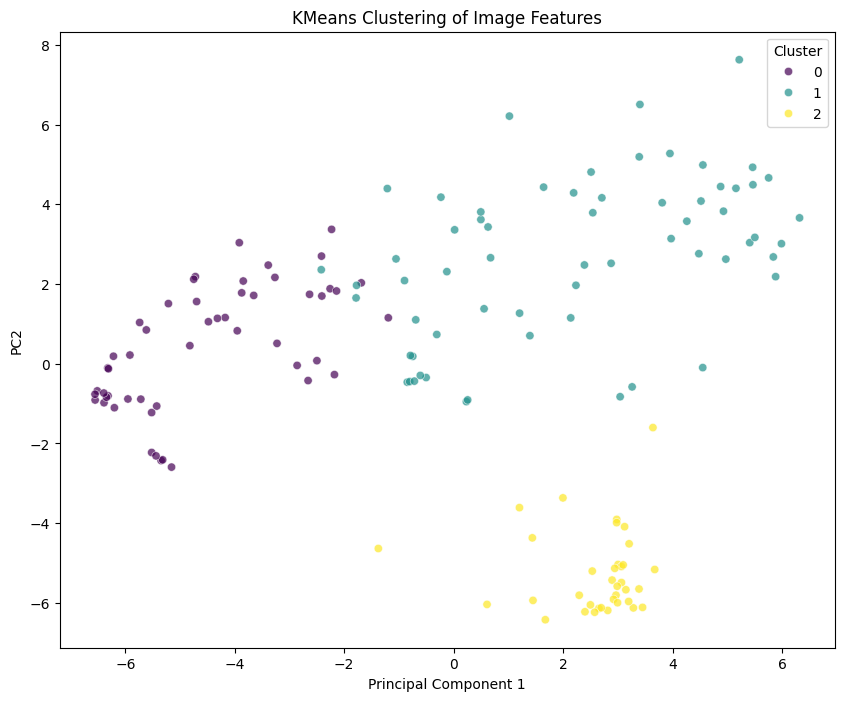

In [49]:
# lets visualize the clusters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.cm as cm

# Reduce the dimensionality of the features to 2D using PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Create a DataFrame for better visualization
import pandas as pd
df = pd.DataFrame(features_2d, columns=['PC1', 'PC2'])
df['Cluster'] = labels
# Create a color map
cmap = cm.get_cmap('viridis', len(set(labels)))
# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette=cmap.colors, alpha=0.7)
plt.title('KMeans Clustering of Image Features')
plt.xlabel('Principal Component 1')
